## Setup helper code, data, and models

In [0]:
%%capture 
!pip install robustness
!git clone https://github.com/ShibaniSanturkar/IAP_InterpretabilityClass.git code
!mv code/*.py .
!wget http://people.csail.mit.edu/tsipras/stuff.zip
!unzip stuff

In [0]:
try: # set up path
    import google.colab, sys, torch
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")  
except:
    pass

In [3]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import torch as ch
import torchvision.transforms as transforms

# We also use the robustness library (https://robustness.readthedocs.io/en/latest/) for some 
# convenient functionality.
from robustness.tools.vis_tools import show_image_row

import helpers 

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Excercise I: Gradients as model interpretations

## Load dataset 

For our interpretability experiments, we will use the ImageNet dataset from the ILSVRC challenge. This is a 1000 class dataset, that has played an important role in developing and evaluating deep learning models.

In [4]:
# Creater a dataset, and a loader to access it. We also need to obtain the 
# input normalization function used during training to use for testing. Finally,
# we also get a label map, that tells us what class a corresponding numeric
# value corresponds to.
in_dataset, in_loader, normalization_function, label_map_IN = helpers.load_dataset(
                                                                'imagenet',
                                                                 batch_size=5,
                                                                 num_workers=1)

==> Preparing dataset imagenet..


We can visualize some samples, along with their labels, from the dataset as follows

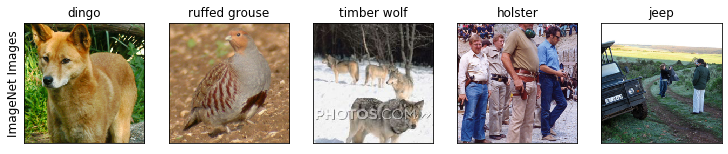

In [5]:
_, (img, targ) = next(enumerate(in_loader))

show_image_row([img],
               ["ImageNet Images"],
               tlist=[[label_map_IN[int(t)] for t in targ]])

## Load model

Next, we need a model to interpret! PyTorch provides access to a large range of pre-trained deep networks (for a full list, see <https://pytorch.org/docs/stable/torchvision/models.html>). For example, we can load a ResNet18 using the following code.

In [6]:
std_model = helpers.load_model('resnet18')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.8MB/s]


### Compute and visualize gradient
We will now compute and visualize the gradient of the loss with respect to the input. For every image pixel, the gradient tells us how the loss changes if we vary that pixel slightly. The gradient can be easily computed using a modern auto-diff framework (in our case PyTorch).

We have already implemented the gradient computation for you since there can be subtle bugs, but **make sure to check and understand the `get_gradient` method in `helpers.py`**. 

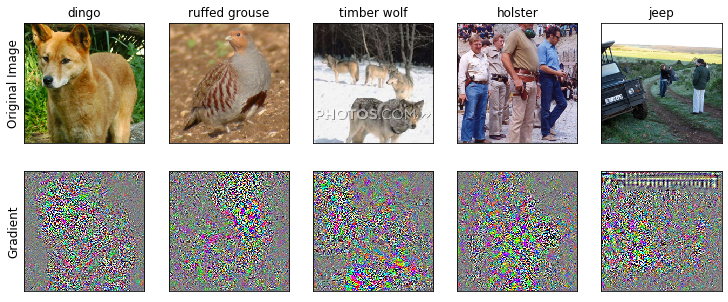

In [7]:
# Compute the gradient of the loss, with respect to the input.

grad, _ = helpers.get_gradient(std_model, img, targ, normalization_function)

# We can then visualize the original image, along with the gradient. Note that the gradient may
# not lie within the valid pixel range ([0, 1]), so we need to rescale it using the 
# `visualize_gradient` function.

show_image_row([img, helpers.visualize_gradient(grad)],
               ["Original Image", "Gradient"],
               tlist=[[label_map_IN[int(t)] for t in targ],
                      ["" for _ in targ]])

# Exercise II:  Try SmoothGrad and visualize the interpretations

Fill in the following skeleton to implement SmoothGrad. Recall that SmoothGrad computes the gradient at multiple nearby points (obtained by adding noise) and averages them.

```
def smooth_grad(mod, im, targ, normalization, Nsamples, stdev):
    it = tqdm(range(Nsamples), total=Nsamples)
    total_grad = 0
    for _, n in it:
        ...
    return total_grad / Nsamples
```
    
Then, try using SmoothGrad to interpret a standard model

In [0]:
def smooth_grad(mod, im, targ, normalization,
                Nsamples, stdev):
    # Instead of taking the gradient of a single image, we will take gradients
    # at a bunch of neighborhood points and average their gradients.
    
    it = tqdm(range(Nsamples), total=Nsamples)

    total_grad = 0
    for _ in it:
        
        # Create a noisy version of the input image
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        # Compute gradient at noised version of the image
        grad, _ = helpers.get_gradient(mod, noised_im, targ, normalization)
        total_grad += grad
    
    # Return average gradient
    return total_grad / Nsamples

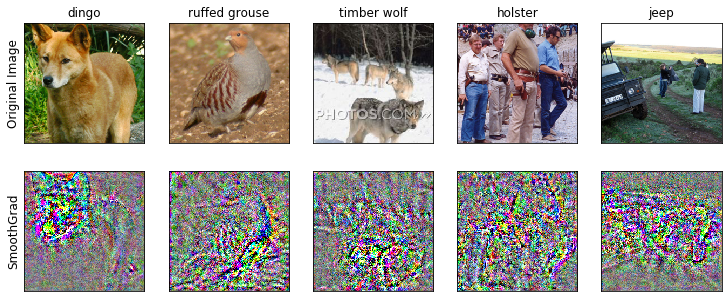

In [9]:
# Compute and visualize smoothed gradient
sgrad = smooth_grad(std_model, img, targ, normalization_function,
                    Nsamples=100, stdev=0.3)

show_image_row([img, helpers.visualize_gradient(sgrad)],
              ["Original Image", "SmoothGrad"],
               tlist=[[label_map_IN[int(t)] for t in targ],
                     ["" for _ in targ]])

# Excercise III: Adversarial examples

It turns out that one can add an *imperceptible* perturbation to any input image and a standard (highly accurate) classifier will misclassify it (or classify it as an adversarially chosen class). These are known as "adversarial examples".

**Finding adversarial examples:** The idea is pretty simple: given a target class (t), we want to find a perturbation ($\delta$) that when added to the input (x) maximizes the likelihood of the target class. At the same time, we want the perturbation to be small: for example lie in a tiny L2 ball around the image (norm computed over pixels). Basically, we want to find a $\delta$ such that

$\delta = argmax_{||\delta||_2 \leq \epsilon} L(x + \delta, t; \theta)$


To maximize this objective without violating the constraint, we use projected gradient descent (PGD, see <https://arxiv.org/abs/1706.06083>). 

We already implemented PGD since there are a few subtle details but **read and understand the `L2PGD` method from `helpers.py`**.

### Try it yourself! 


First choose a target class for every input. (Note that you have a batch of inputs, so you could try different targets for different inputs.)

Next, there are a couple of parameters that you need to choose: 
1. `eps`: maximum size of the perturbation in terms of L2 norm. For e.g., eps=2 implies that $||\delta||_2 \leq 2$
2. `Nsteps`: number of (projected) gradient descent to perform
3. `step_size`: size of each step of (projected) gradient descent

Try varying these parameters and see what happens.

Finally, we will evaluate the model on these adversarial examples and visualize images/predictions on the original (unperturbed) inputs, along with the corresponding adversarial examples.

Target class: cabbage butterfly


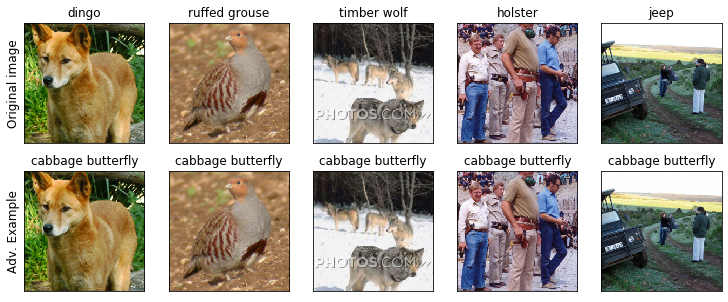

In [10]:
# Select target class
TARGET = 324 # cabbage butterfly but feel free to change

print(f"Target class: {label_map_IN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

# Create adversarial examples
adv_ex = helpers.L2PGD(std_model, img, target_class, normalization_function,
                       step_size=0.5, Nsteps=20, 
                       eps=1.25, targeted=True)
# Evaluate model
with ch.no_grad():
    logits = helpers.forward_pass(std_model, 
                                      adv_ex, 
                                      normalization_function)
    pred_label = logits.argmax(dim=1)

show_image_row([img, adv_ex], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_IN[int(t)] for t in label] \
                      for label in [targ, pred_label]])

# Excercise IV: Playing with robust models

There has been a lot of research towards models that are robust to these perturbations, i.e., so-called *robust models*. Here, we will explore the behavior of a robust model. See <http://gradientscience.org/robust_opt_pt1/> for details on training these models.

### Loading a robust model

For our study today, we will use a pre-trained robust model. We trained this model (ResNet50) on a 9-class subset of the ImageNet dataset. (Developing good robust models for the more complex 1000 class version is still an active area of research.)

In [11]:
# Load the "Restricted" ImageNet dataset
restricted_imagenet_ds, rin_loader, normalization_function, label_map_RIN = \
            helpers.load_dataset('restricted_imagenet', batch_size=5, num_workers=1)

# Load a pre-trained robust model
robust_model = helpers.load_model('robust', restricted_imagenet_ds)

==> Preparing dataset restricted_imagenet..
=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


### Can adversarial examples fool a robust model?

We can now try to fool the robust model using the same procedure as before. Does it succeed? Try varying the attack parameters and see what happens.

Target class: turtle


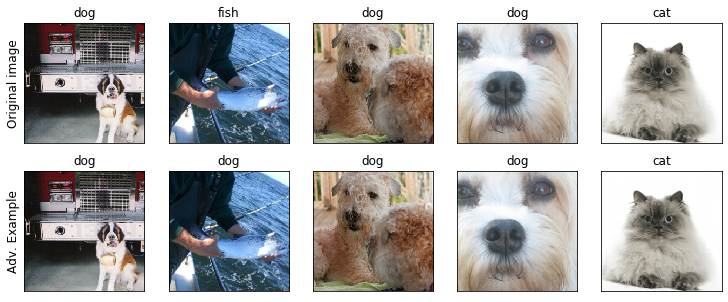

In [12]:
# Load images from the Restricted ImageNet dataset
_, (img, targ) = next(enumerate(rin_loader))

# Then we choose a target label for the attack.
TARGET = 3

print(f"Target class: {label_map_RIN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

# Create adversarial examples
adv_ex = helpers.L2PGD(robust_model, img, target_class, normalization_function,
                       step_size=0.5, Nsteps=20, eps=1.25, targeted=True)

# Evaluate model predictions
with ch.no_grad():
    logit = helpers.forward_pass(robust_model, adv_ex, normalization_function)
    pred_label = logit.argmax(dim=1)

# Visualize adversarial examples

show_image_row([img, adv_ex], 
               ['Original image', 'Adv. Example'],
               tlist=[[label_map_RIN[int(t)] for t in label] \
                      for label in [targ, pred_label]])

# Excercise V: Changing the prediction of a robust model

We know that robust models are not easily fooled by adversarial examples. This tells us that one cannot change the prediction of a robust model using imperceptible L2 perturbations to the input (in contrast to standard models). How can we then modify the input to make the robust model predict a different class?

Try creating adversarial examples as before, but with a larger eps. Our hope is that by increasing the size of the perturbation set, we can find a perturbation that actually causes the model to change its prediction? What do the perturbed inputs, i.e., "*large epsilon adversarial examples*" look like?

Target class: primate


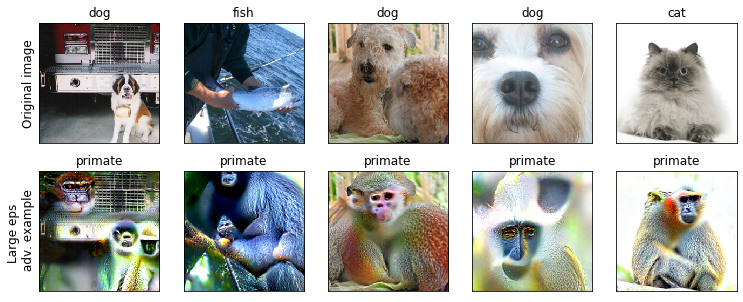

In [13]:
TARGET = 5

print(f"Target class: {label_map_RIN[TARGET]}")

target_class = TARGET * ch.ones_like(targ)

im_targ = helpers.L2PGD(robust_model, img, target_class, normalization_function,
                        step_size=5, Nsteps=20, eps=100, targeted=True)

# Evaluate model predictions
with ch.no_grad():
    logit = helpers.forward_pass(robust_model, im_targ, normalization_function)
    pred_label = logit.argmax(dim=1)

# Visualize
show_image_row([img, im_targ],
              ['Original image', 'Large eps \n adv. example'],
               tlist=[[label_map_RIN[int(t)] for t in label] \
                      for label in [targ, pred_label]])

# Excercise VI: Interpretations for robust models

Based on the previous experiment, we know that large-eps adv. examples change salient image features.

Does this mean that the features that robust models rely on are more human-aligned in a sense?

### VI.I Let's start by looking at their gradients.

What do the gradients of robust models look like? How do they compare to the gradients of a standard model and the output of SmoothGrad?

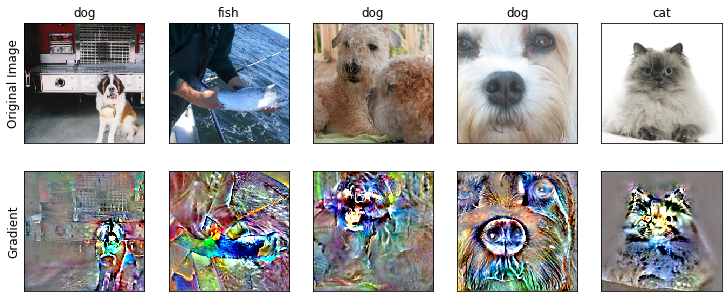

In [14]:
# Get gradient of the loss with respect to the input
grad_rob, _ = helpers.get_gradient(robust_model, img, targ, normalization_function)

# Visualize gradient
show_image_row([img, helpers.visualize_gradient(grad_rob)],
              ["Original Image", "Gradient"],
              tlist=[[label_map_RIN[int(t)] for t in targ],
                     ["" for _ in targ]])

### VI.2 Feature Visualization

Another popular interpretability technique is known as feature visualization. Here, the goal is to find an input that maximizes a feature (a particular neuron in the deep network), instead of just trying to maximize the loss (as we did before with gradients).

You could now try to implement feature visualization yourself. For instance, the following function gives you, for specific inputs, the model's feature vector (the layer before the final linear classifier). 

In [15]:
# Getting the feature representation from the model
with ch.no_grad():
    feats = helpers.get_features(robust_model, img, normalization_function)
    print(f"Dimensions of the feature vector: {feats.shape[1]}")

Dimensions of the feature vector: 2048


#### Implement a loss function to perform feature visualization

Fill in the skeleton below to create a feature visualization loss function. Our goal is to maximize the `feature_number` coordinate of the feature vector.

```
def feature_maximization_loss(mod, im, feature_number, normalization_function):
    feature_vector = helpers.get_features(mod, im, normalization) # Get features for input
    relevant_coordinate = ch.gather(feature_vector, 1, feature_number[:, None]) 
    loss = ?
    return loss
```

In [0]:
# Feature visualization loss: Try to find an input that maximizes a specific feature

def feature_maximization_loss(mod, im, feature_number, normalization):
    # Get feature vector for inputs
    fr = helpers.get_features(mod, im, normalization)
    # We will maximize the `targ` coordinate of the feature vector for every input
    loss = ch.mean(ch.gather(fr, 1, feature_number[:, None]))
    return loss

#### Visualize the results of feature visualization

You can then supply the `feature_maximization_loss` to the `custom_loss` argument input in `helpers.L2PGD`, and maximize it using the following snippet.

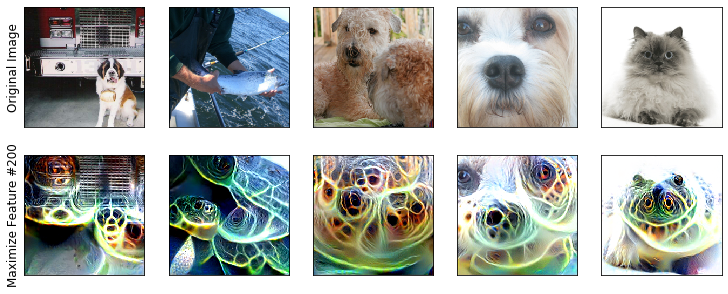

In [17]:
# Chose a feature to visualize
FEATURE = 200 # should be less than the dimension from before

target_feature = FEATURE * ch.ones_like(targ)

# Maximize feature 
im_f = helpers.L2PGD(robust_model, img, target_feature, normalization_function,
                              step_size=5, Nsteps=20, eps=1000, 
                              custom_loss=feature_maximization_loss, 
                              targeted=False)

# Visualize results
show_image_row([img, im_f],
               ["Original Image", f"Maximize Feature #{FEATURE}"])

# Bonus Excercise I: Try feature visualization for robust models starting from noise rather than images

What if we try feature visualization starting from noise?

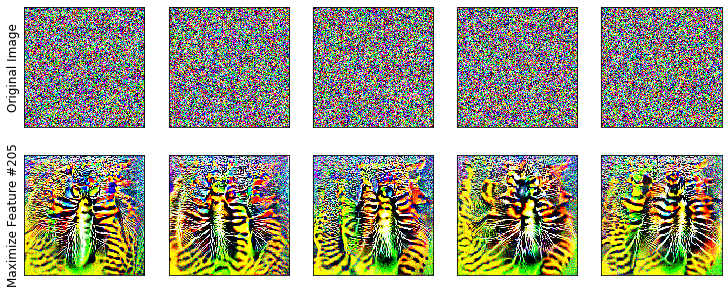

In [18]:
# Create a "noise" image
noise_img = ch.clamp(ch.randn_like(img) + 0.5, 0, 1)

FEATURE = 205
target_feature = FEATURE * ch.ones_like(targ)
im_f = helpers.L2PGD(robust_model, noise_img, target_feature, normalization_function,
                     step_size=5, Nsteps=200, eps=1000, 
                     custom_loss=feature_maximization_loss, 
                     targeted=False)

show_image_row([noise_img, im_f],
                ["Original Image", f"Maximize Feature #{FEATURE}"])